In [1]:
import time
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import random
import gymnasium as gym
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

from gymnasium.wrappers import RecordVideo

In [ ]:
episodes = 1000
timesteps = 500
num_p_av = 100
epsilon = 1
min_epsilon = 0.1
learning_rate = 0.0005
memory_buffer_size = 200_000 
update_period = 8
tau = 0.001
minibatch = 64
gamma = 0.999
decay_rate = 0.99
env = gym.make('LunarLander-v3', render_mode='human')
state_size = env.observation_space.shape[0]
num_actions = env.action_space.n

In [3]:

experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
huber = tf.keras.losses.Huber()
current_state, _ = env.reset()

def mkNetwork ():
    """
    Make the qNetwork and qStarNetwork.
    """
    network = Sequential([
    Input(shape=(state_size,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_actions, activation='linear')
])
    return network

qNetwork = mkNetwork()
qStarNetwork = mkNetwork()
optimizer = Adam(learning_rate)

def compute_loss(experiences, gamma, qNetwork, qStarNetwork):
    """
    Calculates the loss. It returns the Huber loss between
    the y targets and the Q(s,a) values.
    """
    states, actions, rewards, next_states, done_vals = experiences
    maxQsa = tf.reduce_max(qStarNetwork(next_states), axis=-1)

    yTargets = rewards + (gamma * maxQsa * (1 - done_vals))
    qValues = qNetwork(states)

    batch_indices = tf.range(tf.shape(qValues)[0])
    indices = tf.stack([batch_indices, actions], axis=1)
    qValues = tf.gather_nd(qValues, indices)

    loss = huber(yTargets, qValues)

    return loss


def updateTargetNetwork(qNetwork, qStarNetwork):
    """
    Updates the weights of the target Q-Network using a learning rate.
    """
    for targetWeights, qNetWeights in zip(qStarNetwork.weights, qNetwork.weights):
        targetWeights.assign(tau * qNetWeights + (1.0 - tau) * targetWeights)


def getAction(qValues, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(qValues.shape[1])
    else:
        return np.argmax(qValues.numpy())
    

def getNewEps(epsilon):
    """
    Updates the epsilon value for the ε-greedy policy.
    Returns a float with the updated value of epsilon.
    """
    epsilon = max(min_epsilon, decay_rate * epsilon)
    return epsilon

def checkUpdateConditions(t, num_steps, memory_buffer):
    """
    Determines if the conditions are met to perform a learning update.
    Returns a boolean that will be True if conditions are met and False otherwise. 
    """
    if (t + 1) % num_steps == 0 and len(memory_buffer) > minibatch:
        return True
    else:
        return False

def getExperiences(memory_buffer):
    """
    Returns a random sample of experience tuples from the memory buffer. The size of 
    the random sample is determined by the mini-batch size. 
    """
    experiences = random.sample(memory_buffer, k=minibatch)
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]), dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.int32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]), dtype=tf.float32)
    doneValues = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),dtype=tf.float32)

    return (states, actions, rewards, next_states, doneValues)

def agentLearn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, qNetwork, qStarNetwork)

    gradients = tape.gradient(loss, qNetwork.trainable_variables)
    optimizer.apply_gradients(zip(gradients, qNetwork.trainable_variables))

    updateTargetNetwork(qNetwork, qStarNetwork)
    return loss

In [4]:

start = time.time()

def runLunarLander(episodes, timesteps, num_p_av, epsilon, gamma):
    """
    Runs the DQN agent in the LunarLander environment for a specified number of episodes.
    """

    episode_rewards = []
    episode_losses = []
    memory_buffer = deque(maxlen=memory_buffer_size)
    qStarNetwork.set_weights(qNetwork.get_weights())

    for i in range(episodes):
        state, _ = env.reset()
        total_rewards = 0
        episode_loss = 0

        for t in range(timesteps):

            state_qn = np.expand_dims(state, axis=0)
            qValues = qNetwork(state_qn)
            action = getAction(qValues, epsilon)

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            memory_buffer.append(experience(state, action, reward, next_state, done))
            update = checkUpdateConditions(t, update_period, memory_buffer)
            if update:
                experiences = getExperiences(memory_buffer)
                loss = agentLearn(experiences, gamma)
                episode_loss += loss.numpy()

            state = next_state.copy()
            total_rewards += reward
    

            if done:
                break

        episode_rewards.append(total_rewards)
        episode_losses.append(episode_loss / (t // update_period + 1) if (t // update_period + 1) > 0 else 0)
        
        av_latest_points = np.mean(episode_rewards[-num_p_av:])
        epsilon = getNewEps(epsilon)
        # epsilon = getAdaptiveEps(i, epsilon, episode_rewards)


        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}, Epsilon: {epsilon}", end="")

        if (i+1) % num_p_av == 0:
            print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")
    
    total_time = time.time() - start

    print(f"\nTotal Runtime: {total_time:.2f} s ({(total_time / 60):.2f} min)")
    env.close()

    return episode_rewards, episode_losses


Episode 100 | Total point average of the last 100 episodes: -127.45, Epsilon: 0.36603234127322926
Episode 200 | Total point average of the last 100 episodes: -48.39, Epsilon: 0.133979674857961753
Episode 300 | Total point average of the last 100 episodes: 7.34, Epsilon: 0.1110010587426148963
Episode 400 | Total point average of the last 100 episodes: -25.19, Epsilon: 0.1
Episode 500 | Total point average of the last 100 episodes: 3.51, Epsilon: 0.111
Episode 600 | Total point average of the last 100 episodes: 23.80, Epsilon: 0.1
Episode 700 | Total point average of the last 100 episodes: 49.69, Epsilon: 0.1
Episode 800 | Total point average of the last 100 episodes: 177.48, Epsilon: 0.1
Episode 900 | Total point average of the last 100 episodes: 223.86, Epsilon: 0.1
Episode 1000 | Total point average of the last 100 episodes: 204.90, Epsilon: 0.1

Total Runtime: 3053.53 s (50.89 min)


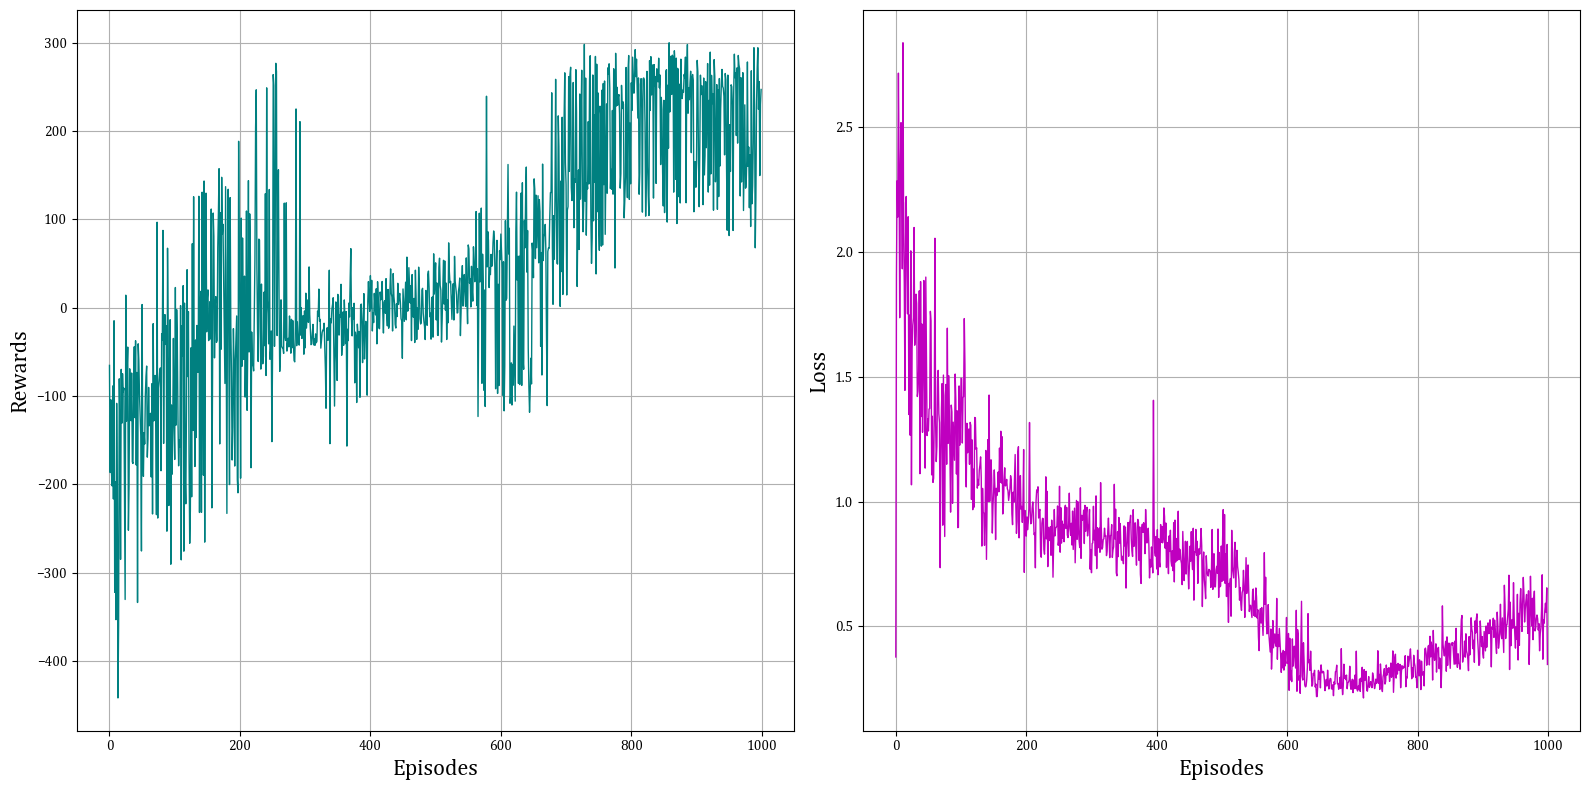

In [5]:
def plotHistory(episode_rewards, episode_losses, **kwargs):
    """
    Plots the total number of points received by the agent after each episode together
    with the moving average (rolling mean), and the loss history.
    """
    lower_limit = 0
    upper_limit = len(episode_rewards)
    plot_data = False

    if kwargs:
        if "lower_limit" in kwargs:
            lower_limit = kwargs["lower_limit"]

        if "upper_limit" in kwargs:
            upper_limit = kwargs["upper_limit"]

        if "plot_data" in kwargs:
            plot_data = kwargs["plot_data"]

    rewards = episode_rewards[lower_limit:upper_limit]
    episode_num = [x for x in range(lower_limit, upper_limit)]

    # Plot Rewards
    plt.figure(figsize=(16, 8))
    plt.rcParams["font.family"] = "Cambria"
    cmfont = {'fontname': 'Cambria'}
    plt.subplot(1, 2, 1)
    if plot_data:
        plt.plot(episode_num, rewards, linewidth=1, color="teal")
    else:
        plt.plot(episode_num, rewards, linewidth=1, color="teal")

    ax = plt.gca()
    plt.grid()
    plt.xlabel("Episodes", fontsize=16, **cmfont)
    plt.ylabel("Rewards", fontsize=16, **cmfont)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(episode_num, episode_losses, linewidth=1, color="m")
    ax = plt.gca()
    plt.grid()
    plt.xlabel("Episodes", fontsize=16, **cmfont)
    plt.ylabel("Loss", fontsize=16, **cmfont)

    plt.tight_layout()
    plt.show()


episode_rewards, episode_losses = runLunarLander(episodes, timesteps, num_p_av, epsilon, gamma)
plotHistory(episode_rewards, episode_losses)

In [ ]:
# Adaptive epsilon decay 
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay= 1000
epsilon_boost = 0.2         
adaptive_check_window = 50  
adaptive_drop_threshold = -50

def getAdaptiveEps(episode, base_epsilon, reward_history):
    epsilon = max(epsilon_end, epsilon_start - (episode / epsilon_decay) * (epsilon_start - epsilon_end))
    
    if len(reward_history) >= 2 * adaptive_check_window:
        recent_avg = np.mean(reward_history[-adaptive_check_window:])
        past_avg = np.mean(reward_history[-2 * adaptive_check_window:-adaptive_check_window])
        if recent_avg - past_avg < adaptive_drop_threshold:
            epsilon = min(1.0, epsilon + epsilon_boost)
    
    return epsilon
